 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework, we will build off of the lessons from last homework. Your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!

### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

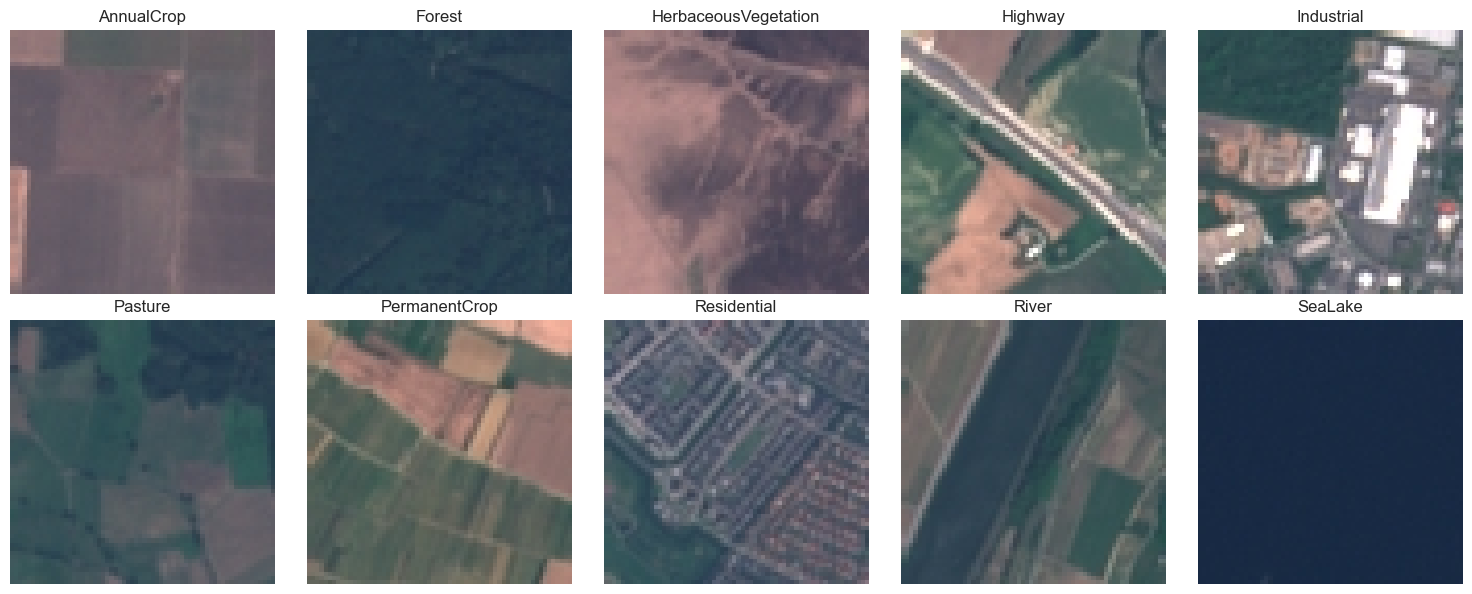

In [5]:
# Plot one image from each class in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, label in enumerate(os.listdir(url)):
    img_path = os.path.join(url, label, os.listdir(os.path.join(url, label))[0])
    img = io.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Load images and labels into numpy arrays
images = []
labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)
images = np.array(images)
labels = np.array(labels)

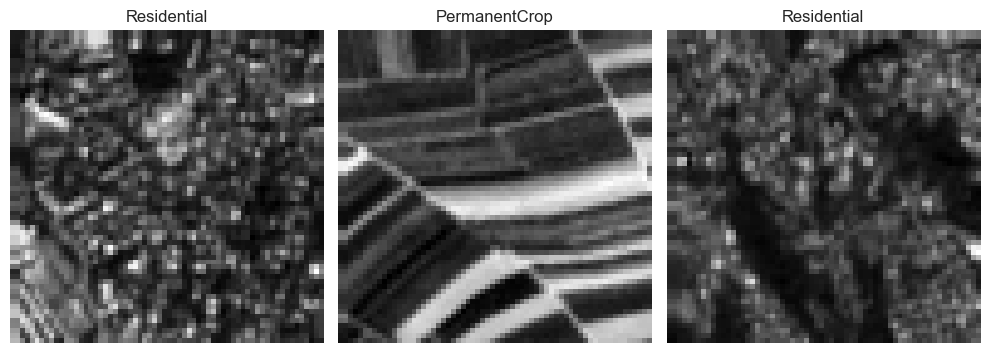

In [10]:
# Plot three random grayscale images with their labels
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs = axs.flatten()
for i in range(3):
    idx = random.randint(0, len(images)-1)
    axs[i].imshow(images[idx], cmap='gray')
    axs[i].set_title(labels[idx])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

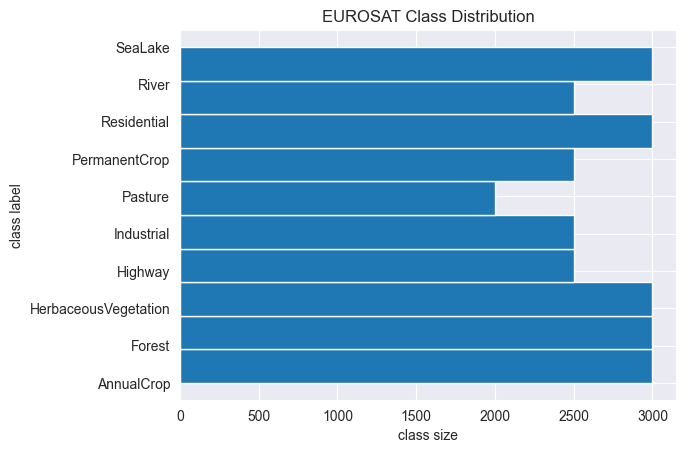

In [13]:
# Plot histogram of label distribution
plt.hist(labels, bins=10, orientation='horizontal')
plt.yticks(range(len(os.listdir(url))), os.listdir(url))
plt.xlabel('class size')
plt.ylabel('class label')
plt.title('EUROSAT Class Distribution')
plt.show()

In [44]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# define the number of samples to generate
n_samples = labels.shape[0]/1000

# generate augmented samples
augmented_images = []
augmented_labels = []
for X_batch, y_batch in datagen.flow(images, labels, batch_size=n_samples):
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) == 5:  # stop after generating 5 batches (i.e., 5000 samples)
        break

# concatenate the augmented data with the original data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (27000, 64, 64))

In [14]:
# Split data into training and testing sets with an equal % of each class in each set
from sklearn.model_selection import train_test_split
img_train, img_test, lab_train, lab_test = train_test_split(images, labels, test_size=0.5, stratify=labels)

# flatten images
img_train = img_train.reshape(img_train.shape[0], -1)
img_test = img_test.reshape(img_test.shape[0], -1)

In [18]:
img_train.shape

(13500, 4096)

In [19]:
img_test.shape

(13500, 4096)

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.

First, in order to pass our data into the neural net, we need to convert our labels into one-hot encoded vectors. We will use the LabelEncoder and to_categorical functions from Keras to do this.

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Define the number of classes and input shape
num_classes = 10
input_shape = (4096,)

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
lab_train_int = le.fit_transform(lab_train)
lab_test_int = le.transform(lab_test)

# convert integer-encoded labels to one-hot encoded labels
lab_train_onehot = to_categorical(lab_train_int, num_classes)
lab_test_onehot = to_categorical(lab_test_int, num_classes)

In [39]:
# Define the number of epochs to test
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Epoch 1/10
95/95 [==============================] - 1s 13ms/step - loss: 2.3797 - accuracy: 0.1285 - val_loss: 2.2323 - val_accuracy: 0.1519
Epoch 2/10
95/95 [==============================] - 1s 11ms/step - loss: 2.2294 - accuracy: 0.1521 - val_loss: 2.2326 - val_accuracy: 0.1393
Epoch 3/10
95/95 [==============================] - 1s 12ms/step - loss: 2.2012 - accuracy: 0.1598 - val_loss: 2.1761 - val_accuracy: 0.1630
Epoch 4/10
95/95 [==============================] - 1s 11ms/step - loss: 2.1701 - accuracy: 0.1783 - val_loss: 2.1603 - val_accuracy: 0.2022
Epoch 5/10
95/95 [==============================] - 1s 10ms/step - loss: 2.1452 - accuracy: 0.2030 - val_loss: 2.1418 - val_accuracy: 0.1696
Epoch 6/10
95/95 [==============================] - 1s 10ms/step - loss: 2.1385 - accuracy: 0.2081 - val_loss: 2.1212 - val_accuracy: 0.2363
Epoch 7/10
95/95 [==============================] - 1s 10ms/step - loss: 2.1249 - accuracy: 0.2325 - val_loss: 2.1442 - val_accuracy: 0.2185
Epoch 8/10
95

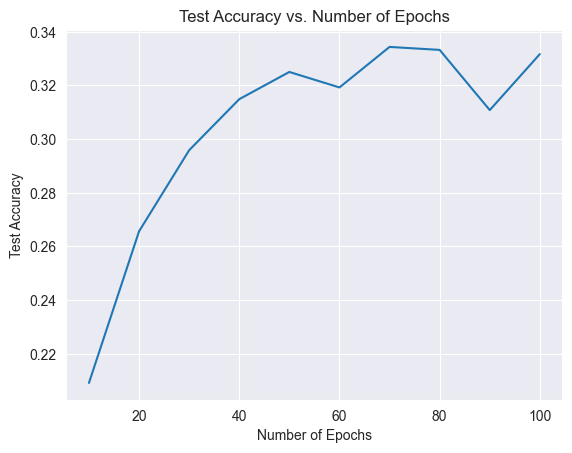

In [40]:
# Initialize an empty list to store the test accuracy at each epoch
test_acc = []

# Loop over the number of epochs and train the model at each epoch
for e in epochs:
    # Define the model architecture
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(img_train, lab_train_onehot, batch_size=128, epochs=e, verbose=1, validation_split=0.1)

    # Evaluate the model on test data
    score = model.evaluate(img_test, lab_test_onehot, verbose=0)
    test_acc.append(score[1])

# Plot the test accuracy at each epoch
import matplotlib.pyplot as plt
plt.plot(epochs, test_acc)
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

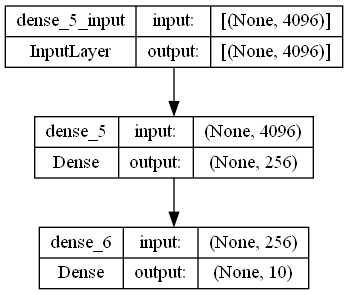

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

Epoch 1/10
95/95 [==============================] - 1s 12ms/step - loss: 2.3183 - accuracy: 0.1187 - val_loss: 2.2709 - val_accuracy: 0.1281
Epoch 2/10
95/95 [==============================] - 1s 10ms/step - loss: 2.2287 - accuracy: 0.1466 - val_loss: 2.1950 - val_accuracy: 0.1422
Epoch 3/10
95/95 [==============================] - 1s 9ms/step - loss: 2.1764 - accuracy: 0.1770 - val_loss: 2.1803 - val_accuracy: 0.2259
Epoch 4/10
95/95 [==============================] - 1s 9ms/step - loss: 2.1330 - accuracy: 0.2089 - val_loss: 2.1118 - val_accuracy: 0.1807
Epoch 5/10
95/95 [==============================] - 1s 9ms/step - loss: 2.0679 - accuracy: 0.2542 - val_loss: 2.0361 - val_accuracy: 0.2926
Epoch 6/10
95/95 [==============================] - 1s 9ms/step - loss: 2.0144 - accuracy: 0.2771 - val_loss: 1.9872 - val_accuracy: 0.2881
Epoch 7/10
95/95 [==============================] - 1s 9ms/step - loss: 1.9513 - accuracy: 0.2945 - val_loss: 1.9325 - val_accuracy: 0.2696
Epoch 8/10
95/95 [

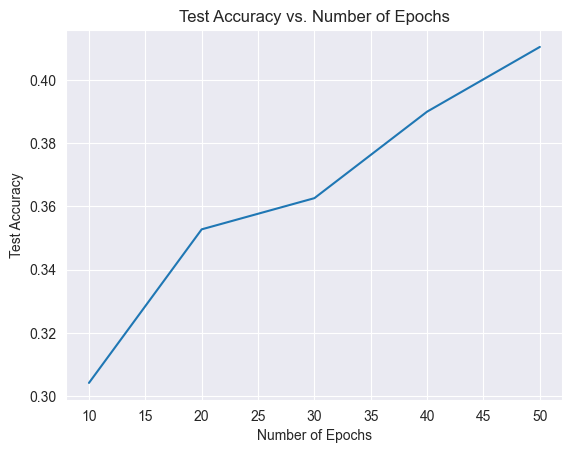

In [37]:
# Initialize an empty list to store the test accuracy at each epoch
test_acc2 = []

# Loop over the number of epochs and train the model at each epoch
for e in epochs:
    # Define the model architecture
    model2 = Sequential()
    model2.add(Dense(256, activation='relu', input_shape=input_shape))
    model2.add(Dense(128, activation='relu'))
    model2.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history2 = model2.fit(img_train, lab_train_onehot, batch_size=128, epochs=e, verbose=1, validation_split=0.1)

    # Evaluate the model on test data
    score2 = model2.evaluate(img_test, lab_test_onehot, verbose=0)
    test_acc2.append(score2[1])

# Plot the test accuracy at each epoch
import matplotlib.pyplot as plt
plt.plot(epochs, test_acc2)
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

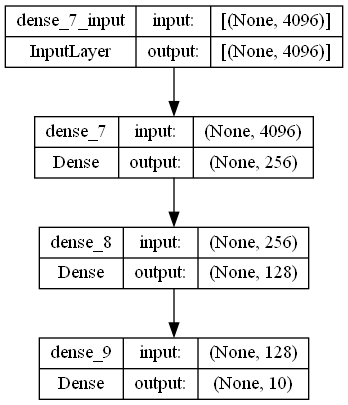

In [28]:
from keras.utils.vis_utils import plot_model

plot_model(model2, show_shapes=True, show_layer_names=True)

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

In [30]:
# Initialize an empty list to store the test accuracy at each epoch
test_acc3 = []

# Loop over the number of epochs and train the model at each epoch
for e in epochs:
    # Define the model architecture
    model3 = Sequential()
    model3.add(Dense(256, activation='relu', input_shape=input_shape))
    model3.add(Dropout(0.5))
    model3.add(Dense(128, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(64, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(32, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history3 = model3.fit(img_train, lab_train_onehot, batch_size=128, epochs=e, verbose=1, validation_split=0.1)

    # Evaluate the model on test data
    score3 = model3.evaluate(img_test, lab_test_onehot, verbose=0)
    test_acc3.append(score3[1])

# Plot the test accuracy at each epoch
import matplotlib.pyplot as plt
plt.plot(epochs, test_acc3)
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               1048832   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)               

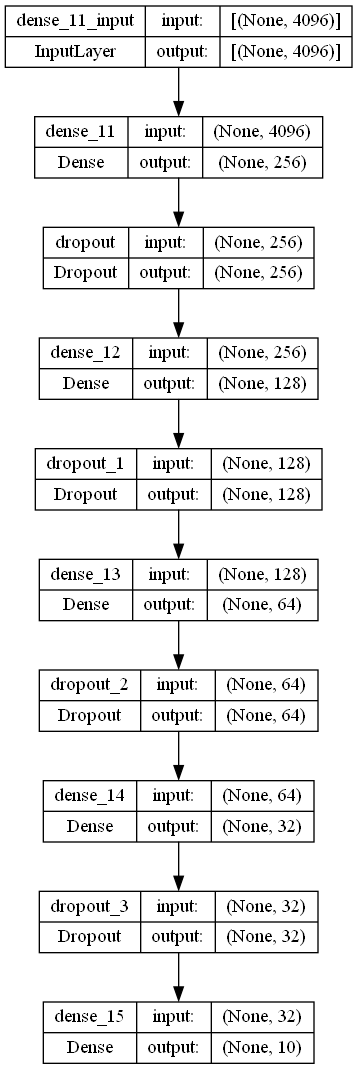

In [31]:
from keras.utils.vis_utils import plot_model

plot_model(model3, show_shapes=True, show_layer_names=True)

### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [45]:
# Load RGB images and labels into numpy arrays
rgb_images = []
rgb_labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        rgb_images.append(image)
        rgb_labels.append(subfolder)
rgb_images = np.array(rgb_images)
rgb_labels = np.array(rgb_labels)

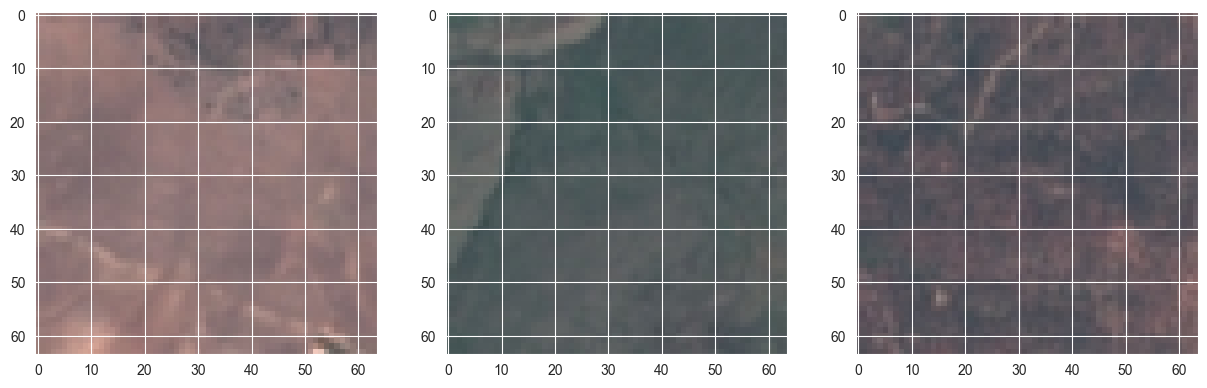

In [46]:
# plot three random images
import matplotlib.pyplot as plt
import random
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(rgb_images[random.randint(0, len(rgb_images))])
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
rgb_img_train, rgb_img_test, rgb_lab_train, rgb_lab_test = train_test_split(rgb_images, rgb_labels, test_size=0.5, stratify=labels)

In [48]:
# fit label encoder and transform labels
rgb_lab_train_int = le.fit_transform(rgb_lab_train)
rgb_lab_test_int = le.transform(rgb_lab_test)

# convert integer-encoded labels to one-hot encoded labels
rgb_lab_train_onehot = to_categorical(rgb_lab_train_int, num_classes)
rgb_lab_test_onehot = to_categorical(rgb_lab_test_int, num_classes)

In [49]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=rgb_img_train[0].shape))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model4.summary()

# Train the model
history4 = model4.fit(rgb_img_train, rgb_lab_train_onehot, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

# Evaluate the model on test data
score4 = model4.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)      

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

In [52]:
# maybe try implementing an ensemble model with majority voting?

import keras

# this is coming from the best model that I built in model 3--there, I had a roughly 70% classification accuracy on the full dataset

batch_size = 128
full_num_classes = 10
full_epochs = 20

# create a CNN
model5 = Sequential()

model5.add(Conv2D(16, kernel_size=5, padding='same', activation='elu', input_shape=(64, 64, 3)))
model5.add(MaxPooling2D())

model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(MaxPooling2D())

model5.add(Conv2D(64, 3, padding='same', activation='elu'))
model5.add(Conv2D(64, 3, padding='same', activation='elu'))

model5.add(Flatten())
model5.add(Dense(128, activation='elu'))

model5.add(Dense(full_num_classes, activation='softmax'))

model5.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model5.fit(rgb_img_train, rgb_lab_train_onehot,
            batch_size=batch_size,
            epochs=full_epochs,
            verbose=1,
            validation_data=(rgb_img_test, rgb_lab_test_onehot))

score = model5.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/20
106/106 [==============================] - 22s 206ms/step - loss: 4.1913 - accuracy: 0.3499 - val_loss: 1.4511 - val_accuracy: 0.4576
Epoch 2/20
106/106 [==============================] - 22s 203ms/step - loss: 1.1321 - accuracy: 0.5839 - val_loss: 0.9113 - val_accuracy: 0.6836
Epoch 3/20
106/106 [==============================] - 22s 205ms/step - loss: 0.9053 - accuracy: 0.6776 - val_loss: 0.8273 - val_accuracy: 0.6935
Epoch 4/20
106/106 [==============================] - 21s 198ms/step - loss: 0.7833 - accuracy: 0.7150 - val_loss: 1.0119 - val_accuracy: 0.6413
Epoch 5/20
106/106 [==============================] - 21s 198ms/step - loss: 0.6996 - accuracy: 0.7435 - val_loss: 0.8581 - val_accuracy: 0.7046
Epoch 6/20
106/106 [==============================] - 21s 197ms/step - loss: 0.7118 - accuracy: 0.7437 - val_loss: 0.7329 - val_accuracy: 0.7335
Epoch 7/20
106/106 [==============================] - 21s 198ms/step - loss: 0.5772 - accuracy: 0.7892 - val_loss: 0.6406 - val_ac

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.